In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.mynetwork_uu import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.cuda.is_available())

cuda
True


In [3]:
model = Unet(device).to(device)
# model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
# vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
# for x in vgg.parameters():
#     x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

In [4]:
lr1 = 0.001
lr2 = 0.0003

# lr_fast = 0.0003
# lr_slow = 0.0004

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300


In [5]:
loss_li = [0]*100


In [6]:
pil = Image.open(f"./source_pic/emma.jpg")
ori_size = pil.size[::-1]
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False
# pic[:,1,:,:] = 0

C:\Users\win10\AppData\Local\Temp\ipykernel_9080\39558398.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
E:\Anaconda\envs\sth\lib\site-packages\torchvision\transforms\transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [7]:
# source = "photo"
# source = "cat"
# source = "CG picture"
source = "happy"
# source = "man"
# source = "cartoon"
# source = "red car"

# target = "gold car"
# target = "Mark Elliot Zuckerberg"
# target = "Mona Lisa by Leonardo da Vinci"
target = "angry"
# target = "girl"
# target = "Neon Light"
# target = "black car"
# target = "pop art"
# target = "baby girl"
# target = "Watercolor Art with Thick Brush"
# target = "Pixar"
# target = "watercolor painting with thick brush"
# target = "starry night by Van Gogh"
# target = "the scream by Edvard Munch"
# target = "Monet"
# target = "cyberpunk 2077"
# target = "oil painting with thick brush"
# target = "man with dark black skin and black hair"
# target = "The great wave off kanagawa by Hokusai"
# target = "mosaic"
# target = "fire"
# target = "Chinese Brush Painting of mountains in black and white"
# target = "snowy"
# target = "sketch with pencil"
# target = "pop art of night city"
# target = "cubism"
# target = "Cartoon"
# target = "anime"
# target = "white marble carving"
# target = "steampunk"


In [8]:
path = "result/result02.jpg"

In [9]:
dli = []
nli = []

In [10]:
patch_file = open(f"./data/nums.txt", mode="w")

In [11]:
def train(iteration1, iteration2, pic, source, target):


    input = pic

    # pic_f = get_features(vgg_normalize(pic), vgg)
    # print(model.parameters())
    opt = optim.Adam(model.parameters(), lr=lr1)
    for i in range(iteration1):
        opt.zero_grad()
        neo_pic = model(input)
        loss = mseloss(pic, neo_pic) * 1

        # loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        loss.backward()
        opt.step()

        with torch.no_grad():
            print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 50) == 0:
        #     pil.save(f"./pic1/{(i + 1) // 50}.jpg")
    with torch.no_grad():
        neo_pic = model(input)
        pil = topil(neo_pic.squeeze(0).cpu())
        pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
        pil.save(f"mid.jpg")


    # torch.save(model,'unet.pth')

    # model = torch.load('unet.pth')

    # pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    # opt_fast = optim.Adam(model.parameters(), lr=lr_fast)
    # opt_slow = optim.Adam(model.parameters(), lr=lr_slow)
    # opt_loss = optim.Adam(cliploss.parameters(), lr=lr_slow)

    for i in range(iteration2):


        opt.zero_grad()
        # opt_slow.zero_grad()
        # opt_fast.zero_grad()

        neo_pic = model(input)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(pic, source, neo_pic, target)

        gol_loss = 0
        # gol_loss += cliploss.forward_gol(pic, source, neo_pic, target)

        content_loss = 0
        # content_loss += mseloss(pic, neo_pic)
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        # patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        norm_loss += cliploss.forward_prior(pic, source, neo_pic, target)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda


        patch_loss_fast,patch_loss_slow, li = cliploss.forward_patch_sec(pic, source, neo_pic, target)
        patch_loss_fast *= patch_lambda
        patch_loss_slow *= patch_lambda

        for x in model.res2.parameters():
            x.requires_grad = False
        patch_loss_slow.backward(retain_graph=True)
        for x in model.res2.parameters():
            x.requires_grad = True

        for x in model.res.parameters():
            x.requires_grad = False
        for x in model.conv3.parameters():
            x.requires_grad = False
        for x in model.upsample3.parameters():
            x.requires_grad = False
        for x in model.deconv3.parameters():
            x.requires_grad = False
        patch_loss_fast.backward(retain_graph=True)
        for x in model.res.parameters():
            x.requires_grad = True
        for x in model.conv3.parameters():
            x.requires_grad = True
        for x in model.upsample3.parameters():
            x.requires_grad = True
        for x in model.deconv3.parameters():
            x.requires_grad = True

        loss.backward()
        # (loss+patch_loss_fast+patch_loss_slow).backward()


        opt.step()

        # opt_fast.step()
        # opt_slow.step()

        with torch.no_grad():
            # loss_li[i]+=(loss+patch_loss_fast+patch_loss_slow).item()
            # print("iter:", i + 1, "fast_loss:", patch_loss_fast.item(), "slow_loss:", patch_loss_slow.item())
            # print("iter:", i + 1, "loss:", (loss+patch_loss_fast+patch_loss_slow).item())

            patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)*patch_lambda
            loss_li[i] += (loss+patch_loss).item()
            print("iter:", i + 1, "loss:", (loss+patch_loss).item())


            for x in li:
                patch_file.write(str(x)+" ")

            patch_file.write("\n")

            if (i+1)%10==0  or i==0:
                neo_pic = model(input)
                pil = topil(neo_pic.squeeze(0).cpu())
                pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
                pil.save(f"mid/{i//10}.jpg")

            # gli.append(gol_loss.item()*gol_lambda)
            dli.append(dir_loss.item()*dir_lambda)
            nli.append(norm_loss.item()*norm_lambda)

            # if (i+1)%4==0 and cliploss.patch_size>=64:
            #     cliploss.patch_size-=8



        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    # return  model(input)
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)





In [12]:
start = time.time()
train(100, 100, pic, source, target)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

iter: 1 loss: 0.07268472015857697
iter: 2 loss: 0.03409094363451004
iter: 3 loss: 0.018431544303894043
iter: 4 loss: 0.010410664603114128
iter: 5 loss: 0.006109039299190044
iter: 6 loss: 0.0037842988967895508
iter: 7 loss: 0.0024261660873889923
iter: 8 loss: 0.0017546284943819046
iter: 9 loss: 0.0015074418624863029
iter: 10 loss: 0.0014612569939345121
iter: 11 loss: 0.0014824771787971258
iter: 12 loss: 0.0015189655823633075
iter: 13 loss: 0.001550815301015973
iter: 14 loss: 0.001563135883770883
iter: 15 loss: 0.0015458952402696013
iter: 16 loss: 0.0014968812465667725
iter: 17 loss: 0.00142448372207582
iter: 18 loss: 0.001341901603154838
iter: 19 loss: 0.0012599111068993807
iter: 20 loss: 0.0011840184452012181
iter: 21 loss: 0.0011161116417497396
iter: 22 loss: 0.001057910150848329
iter: 23 loss: 0.001011430169455707
iter: 24 loss: 0.0009750449098646641
iter: 25 loss: 0.0009442446753382683
iter: 26 loss: 0.000913680880330503
iter: 27 loss: 0.0008805395918898284
iter: 28 loss: 0.00084503

C:\Users\win10\AppData\Local\Temp\ipykernel_9080\1332957929.py:31: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
C:\Users\win10\AppData\Local\Temp\ipykernel_9080\1332957929.py:135: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)


In [13]:
neo_pic = model(pic)
pil = topil(neo_pic.squeeze(0).cpu())
pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
pil.save(path)

C:\Users\win10\AppData\Local\Temp\ipykernel_9080\3219620664.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)


In [14]:
patch_file.close()

In [15]:
file_uu = open("neo_uu.txt", "r")
read_loss_li = file_uu.readline()
read_loss_li = [float(x) for x in read_loss_li.split()]
if not read_loss_li:
    read_loss_li = [0]*100

cur_times = int(file_uu.readline())
file_uu.close()

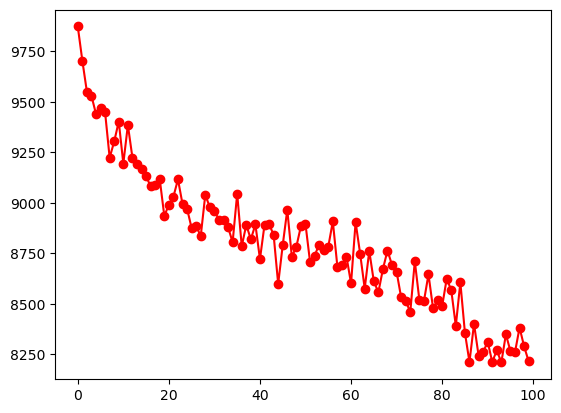

In [16]:
import matplotlib.pyplot as plt
x = [i for i in range(100)]
plt.plot(x,loss_li,color="red",marker="o")


In [17]:
for i in range(100):
    loss_li[i]+=read_loss_li[i]
with open(file = "neo_uu.txt", mode = "w") as file:
    for i in loss_li:
        file.write(str(i)+" ")
    file.write("\n")
    file.write(str(cur_times+1))


In [18]:
# x = [i for i in range(100)]
# plt.plot(x,gli,color="red",marker="o")

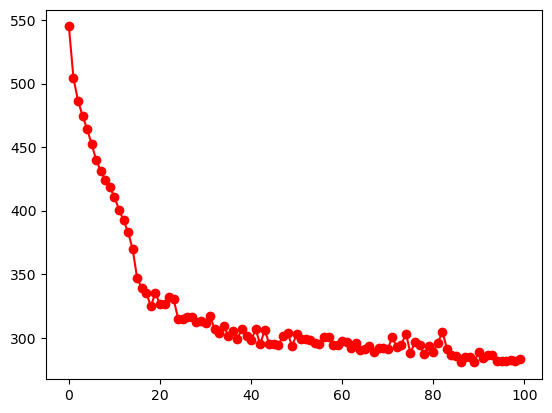

In [19]:
x = [i for i in range(100)]
plt.plot(x,dli,color="red",marker="o")

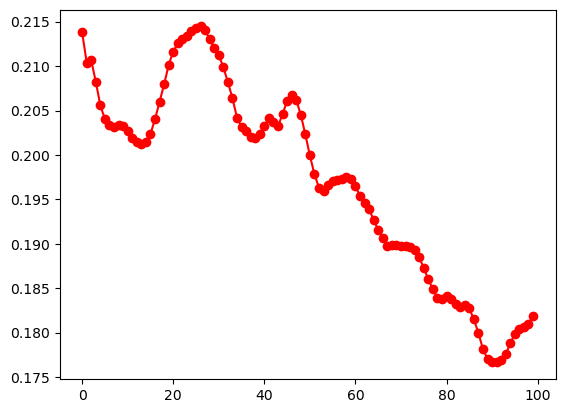

In [20]:
x = [i for i in range(100)]
plt.plot(x,nli,color="red",marker="o")

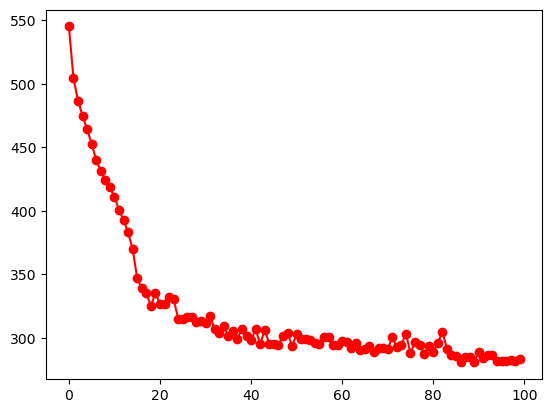

In [21]:
x = [i for i in range(100)]
# li = [gli[i]+dli[i]+nli[i] for i in range(100)]
li = [dli[i]+nli[i] for i in range(100)]
plt.plot(x,li,color="red",marker="o")

0.50796875


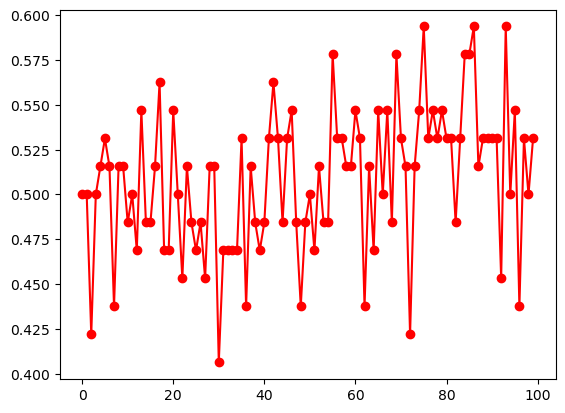

In [22]:
x = [i for i in range(100)]
li = [x/64 for x in cliploss.right_patch]
plt.plot(x,li,color="red",marker="o")
print(sum(cliploss.right_patch)/6400)